## Petroleum Product Demand Forecasting 
This project forecasts the monthly demand for petroleum products such as ATF, Petrol, and Diesel 
to help optimize supply chain and inventory management. 
Using historical consumption data, we predict the future demand using time series forecasting techniques.


In [1]:
# Step 0: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import holidays
from datetime import datetime
import os


In [2]:
# Step 1: Load Data

df = pd.read_csv("D:\\Download\\petroleum_prod_consumption.csv")

# Create a Date column from Month + Year
df['Date'] = pd.to_datetime(df['month'] + " " + df['year'].astype(str))

# Sort by Date
df = df.sort_values('Date')


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12292\3009396762.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['month'] + " " + df['year'].astype(str))


In [3]:
# Add Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['Season'] = df['Date'].dt.month.apply(get_season)


In [4]:
# Add Holiday Flag
indian_holidays = holidays.IND(years=df['year'].unique())
df['IsHolidayMonth'] = df['Date'].apply(lambda d: any(
    (h.year == d.year and h.month == d.month) for h in indian_holidays))

# Convert boolean to int
df['IsHolidayMonth'] = df['IsHolidayMonth'].astype(int)

# Encode Season
df['Season_Code'] = df['Season'].map({
    'Winter': 0,
    'Summer': 1,
    'Monsoon': 2,
    'Post-Monsoon': 3})

# Extract numeric month
df['Month_Num'] = df['Date'].dt.month

In [5]:
# Step 2: Multi-Product Forecasting

metrics_list = []  # store RMSE and MAPE for each product

# Create folder for results
os.makedirs("forecast_results", exist_ok=True)

for product in df['products'].unique():
    print(f"\n🔹 Forecasting for product: {product}")
    product_df = df[df['products'] == product].copy()

    features = ['year', 'Month_Num', 'IsHolidayMonth', 'Season_Code']
    target = 'quantity_in_1000_metric_tonnes'

    X = product_df[features]
    y = product_df[target]

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # XGBoost Model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    metrics_list.append([product, rmse, mape])

    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Save Results
    results = X_test.copy()
    results['Actual'] = y_test.values
    results['Predicted'] = y_pred
    results.to_csv(f"forecast_results/{product}_forecast.csv", index=False)

    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(results.index, results['Actual'], label='Actual')
    plt.plot(results.index, results['Predicted'], label='Predicted')
    plt.legend()
    plt.title(f"Actual vs Predicted Consumption ({product})")
    plt.xlabel("Record Index")
    plt.ylabel("Quantity (1000 Metric Tonnes)")
    plt.savefig(f"forecast_results/{product}_forecast_plot.png")
    plt.close()



🔹 Forecasting for product: LPG
RMSE: 88.49
MAPE: 3.14%

🔹 Forecasting for product: Petroleum coke
RMSE: 187.31
MAPE: 11.12%

🔹 Forecasting for product: Others
RMSE: 263.55
MAPE: 17.52%

🔹 Forecasting for product: Naphtha
RMSE: 150.16
MAPE: 11.89%

🔹 Forecasting for product: MS
RMSE: 196.77
MAPE: 5.87%

🔹 Forecasting for product: Lubricants & Greases
RMSE: 97.05
MAPE: 29.97%

🔹 Forecasting for product: LDO
RMSE: 20.09
MAPE: 25.53%

🔹 Forecasting for product: HSD
RMSE: 712.41
MAPE: 7.86%

🔹 Forecasting for product: FO & LSHS
RMSE: 48.03
MAPE: 7.63%

🔹 Forecasting for product: Bitumen
RMSE: 144.79
MAPE: 14.88%

🔹 Forecasting for product: ATF
RMSE: 105.71
MAPE: 11.76%

🔹 Forecasting for product: SKO
RMSE: 48.68
MAPE: 101.39%


In [1]:
# Visualization
plt.figure(figsize=(10,6))
    plt.plot(results.index, results['Actual'], label='Actual')
    plt.plot(results.index, results['Predicted'], label='Predicted')
    plt.legend()
    plt.title(f"Actual vs Predicted Consumption ({product})")
    plt.xlabel("Record Index")
    plt.ylabel("Quantity (1000 Metric Tonnes)")
    plt.savefig(f"forecast_results/{product}_forecast_plot.png")
    plt.close()

IndentationError: unexpected indent (1472210745.py, line 2)

In [6]:
# Step 3: Save Metrics Summary

metrics_df = pd.DataFrame(metrics_list, columns=['Product', 'RMSE', 'MAPE (%)'])
metrics_df.to_csv("forecast_results/forecast_metrics_summary.csv", index=False)

print("\n✅ Multi-product forecasting completed.")
print(metrics_df)


✅ Multi-product forecasting completed.
                 Product        RMSE    MAPE (%)
0                    LPG   88.485538    3.139485
1         Petroleum coke  187.306165   11.116863
2                 Others  263.551533   17.521493
3                Naphtha  150.155246   11.888595
4                     MS  196.765624    5.872356
5   Lubricants & Greases   97.045467   29.973276
6                    LDO   20.092810   25.534264
7                    HSD  712.410865    7.862838
8              FO & LSHS   48.025595    7.632270
9                Bitumen  144.789754   14.877339
10                   ATF  105.705700   11.758398
11                   SKO   48.675378  101.385845


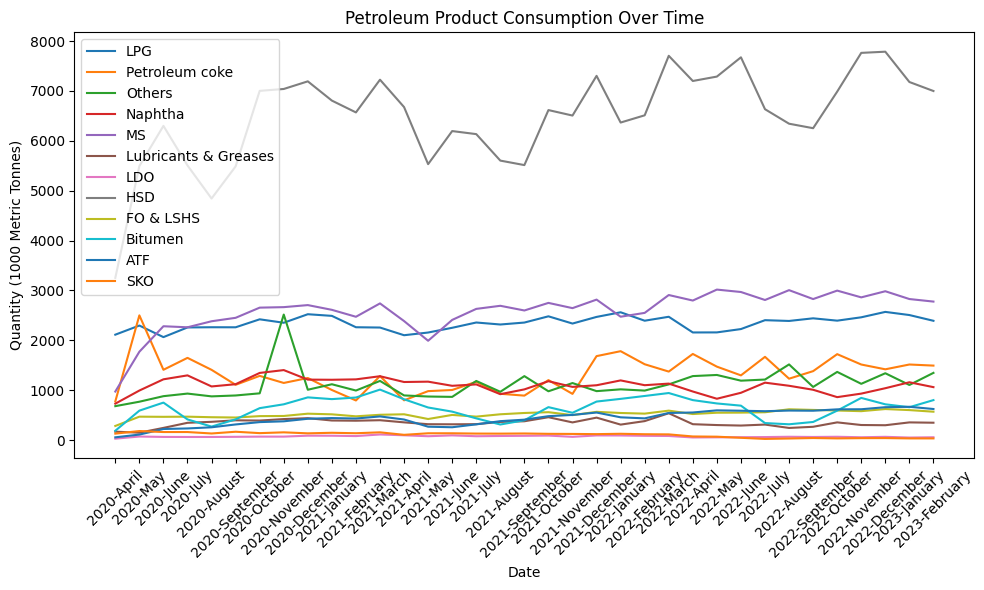

In [10]:
# Simple EDA - Trend over time
plt.figure(figsize=(10,6))
for product in df['products'].unique():
    subset = df[df['products'] == product]
    plt.plot(subset['year'].astype(str) + "-" + subset['month'], subset['quantity_in_1000_metric_tonnes'], label=product)
plt.legend()
plt.title("Petroleum Product Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity (1000 Metric Tonnes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Step 4: Identify the Best Forecast

best_product_row = metrics_df.loc[metrics_df['MAPE (%)'].idxmin()]

print("\n📌 Conclusion:")
print(f"The best forecast accuracy is for '{best_product_row['Product']}' "
      f"with RMSE = {best_product_row['RMSE']:.2f} and MAPE = {best_product_row['MAPE (%)']:.2f}%.")



📌 Conclusion:
The best forecast accuracy is for 'LPG' with RMSE = 88.49 and MAPE = 3.14%.


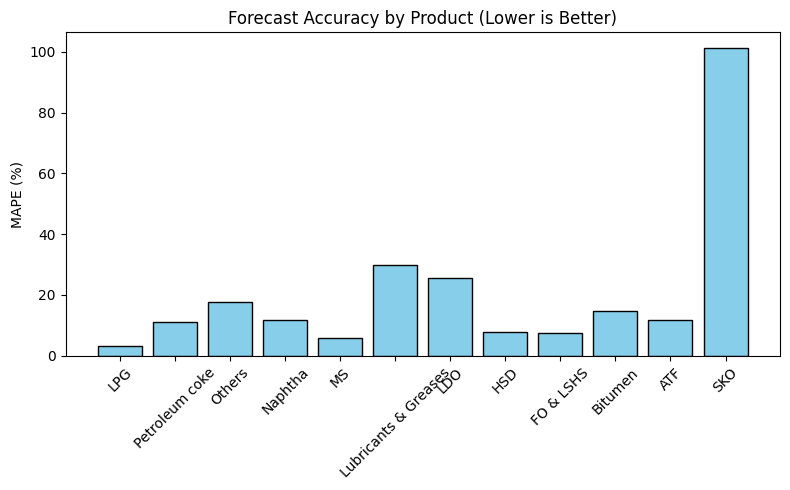

In [11]:
# Step 5: Visualize Forecast Accuracy by Product


plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Product'], metrics_df['MAPE (%)'], color='skyblue', edgecolor='black')
plt.ylabel("MAPE (%)")
plt.title("Forecast Accuracy by Product (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecast_results/forecast_accuracy_comparison.png", dpi=300)
plt.show()




## Conclusion
This project forecasted monthly petroleum product demand using time-series models. LPG achieved the lowest MAPE, indicating the highest prediction accuracy, while Diesel showed stronger seasonal fluctuations.

Accurate demand forecasts can improve refinery planning, optimize logistics, and enhance import/export decisions. Even a 2–3% error reduction can lead to significant cost savings and better operational efficiency